<a href="https://colab.research.google.com/github/ARKA1112/dl-fundamentals/blob/main/self7_4part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using the CIFAR10 dataset

In [1]:


%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch,torchvision,lightning --conda



ModuleNotFoundError: ignored

In [1]:
!pip install -Uq lightning

In [2]:
## Loading the dataset

In [3]:
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from collections import Counter
from lightning.pytorch.loggers import CSVLogger

In [32]:
#Create the CIFAR10 datamodule

class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, batch_size=64,data_path='./', num_workers=10, height_width=(32,32)):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.height_width = height_width

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)

        self.train_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )

        self.test_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )
        return

    def _setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False
        )

        self.train, self.val = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(
            dataset=self.val,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader




In [41]:
dm = Cifar10DataModule()
dm.prepare_data()
dm._setup()

Files already downloaded and verified


In [37]:
for images, labels in  dm.train_dataloader():
  break

images[0].shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 32, 32])

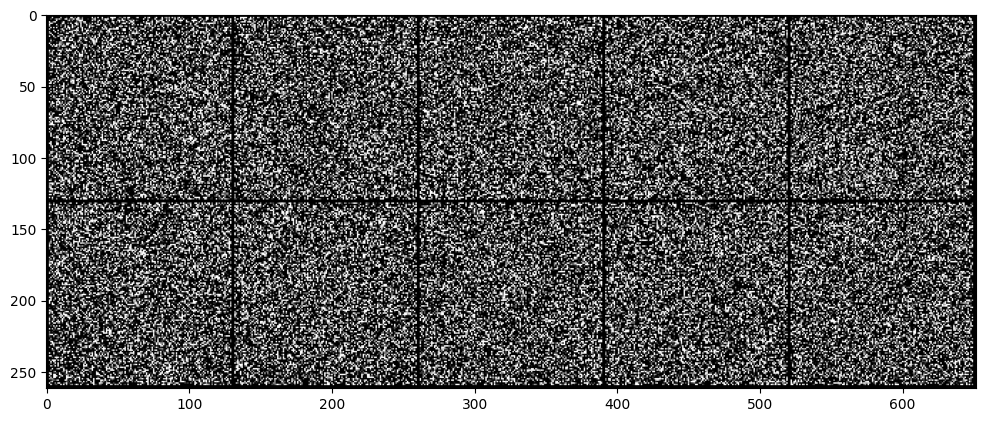

In [38]:
#First lets create an imaginary data
import torch
batch_tensor = torch.randn(10,1,128,128)
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose((grid_img),(1,2,0)))
plt.show()

In [39]:
for images, labels in dm.val_dataloader():
    break



## Plot of data

In [ ]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Cifar10Dataset')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1,2,0)))


In [ ]:
#Now lets check the distrribution

counter = Counter()
for images, labels in dm.test_dataloader():
  counter.update(labels.tolist())

In [ ]:
f'The followin is the distribution of the items{counter.items()}'

In [ ]:
print('majority_class',counter.most_common())
baseline_acc= counter.most_common()[0][1]/sum(counter.values())
baseline_acc

In [ ]:
 counter.most_common()

## Loading the resnet model from torchub

In [ ]:

import torch

entrypoints = torch.hub.list('pytorch/vision',force_reload=True)
for e in entrypoints:
  print(e)

In [24]:
vgg_model = torch.hub.load('pytorch/vision','resnet18',weights=None)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [25]:
vgg_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
#Since the vgg gives 1000 output classes, we need 10 so we will modigy

# class Custom_model(torch.nn.Module):
#   def __init__(self,model):
#     super().__init__()
#     self.layer1 = torch.nn.Linear(1000,10)
#     self.net = model.classifier
#     for p in self.net.parameters():
#       p.requires_grad=False

#   def forward(self,x):
#     x1=self.net(x)
#     print('Original Vgg Cleared')
#     return self.layer1(x1)

# pytorch_model = Custom_model(vgg_model)

In [42]:
#Create the lightning model
class LightningModel(L.LightningModule):
    def __init__(self,model,learning_rate):
      super().__init__()
      self.model = model
      self.learning_rate=learning_rate
      self.save_hyperparameters(ignore=['model'])

      self.train_acc = torchmetrics.Accuracy(task='multiclass',num_classes=10)
      self.val_acc = torchmetrics.Accuracy(task='multiclass',num_classes=10)
      self.test_acc = torchmetrics.Accuracy(task='multiclass',num_classes=10)

    def forward(self,x):
      return self.model(x)

    def _shared_step(self,batch):
      features, true_labels = batch
      logits = self(features)

      loss=torch.nn.functional.cross_entropy(logits,true_labels)
      predicted_labels=torch.argmax(logits,dim=1)
      return loss, true_labels, predicted_labels


    def training_step(self, batch, batch_idx):
      loss, true_labels, predicted_labels = self._shared_step(batch)


      self.log('train_loss', loss)
      self.train_acc(predicted_labels, true_labels)
      self.log('train_acc',self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
      return loss

    def validation_step(self, batch, batch_idx):
      loss, true_labels, predicted_labels = self._shared_step(batch)


      self.log('val_loss', loss)
      self.val_acc(predicted_labels, true_labels)
      self.log('val_acc',self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
      loss, true_labels, predicted_labels = self._shared_step(batch)


      self.log('test_loss', loss)
      self.test_acc(predicted_labels, true_labels)
      self.log('test_loss',self.test_acc)


    def configure_optimizers(self):
      optimizer=torch.optim.SGD(self.parameters(), lr=self.learning_rate)
      return optimizer


lightning_model = LightningModel(model=vgg_model, learning_rate=0.1)
dm = Cifar10DataModule(height_width=(256,256),num_workers=4)
dm.prepare_data()
dm._setup()

Files already downloaded and verified


In [43]:
from lightning.pytorch.tuner import Tuner


In [44]:
trainer = L.Trainer(
    max_epochs=12,
    accelerator='gpu',
    devices=1,
    logger=CSVLogger(save_dir='logs/',name='resnet_lightning'),
    deterministic=True,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [45]:
tuner = Tuner(trainer)

In [49]:
lr_find = tuner.lr_find(model=lightning_model, datamodule=dm,early_stop_threshold=None)

Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:151: UserWarning: You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=136` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=136` reached.
INFO: Learning rate set to 0.04365158322401657
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.04365158322401657
INFO: Restoring states from the checkpoint path at /content/.lr_find_95ff8ab6-3a5f-483d-b01e-d04d1c8682d3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_95ff8ab6-3a5f-483d-b01e-d04d1c8682d3.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_95ff8ab6-3a5f-483d-b01e-d04d1c8682d3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_95ff8ab6-3a5f-483d-b01e-d04d1c8682d3.ckpt


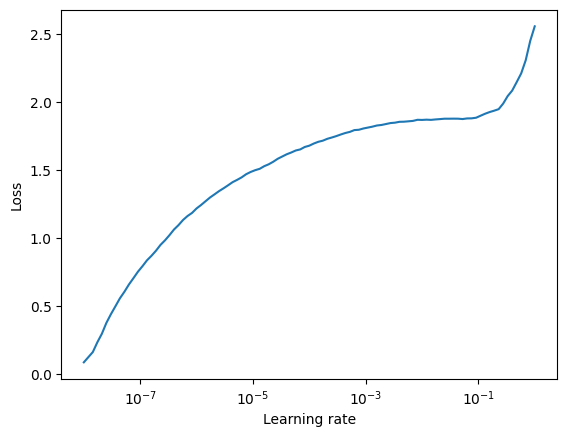

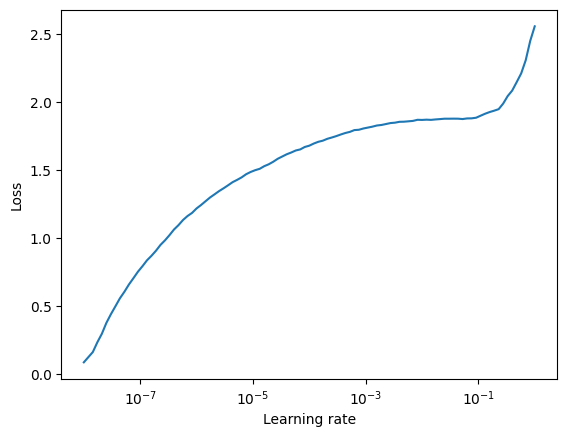

In [51]:
lr_find.plot()

In [52]:
lightning_model = LightningModel(model=vgg_model, learning_rate=lr_find.suggestion())

In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.7 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.7 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.7 M    Trainable params
0         Non-tra

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]